## Анализ роста Charge
Подходит для анализа роста на данных с небольшой девиацией.<br>
Анализ выполняется с помощью поиска min, max, std значений

In [16]:
import pyodbc
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [4]:
# Download data from OCS DB

start_date = '2019-04-01 00:00:00'
end_date = '2019-04-09 00:00:00'

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select CONVERT(VARCHAR(8), u.usage_date, 3) as 'REP_DATE'
,u.mcc,u.mnc,uc.account_id,u.usage_type
,sum(u.quantity) as quantity,sum(uc.charge) as charge,sum(uc.cost) as cost
from [10028_usage2019-04].[dbo].[USAGE] u
inner join [10028_usage2019-04].[dbo].[USAGE_CHARGES] uc
on u.USAGE_ID = uc.USAGE_ID
where u.usage_date >= 
''' + "'" + start_date + "' and u.usage_date < '" + end_date + "' " +\
'''
GROUP BY CONVERT(VARCHAR(8), u.usage_date, 3),u.mcc,u.mnc,uc.account_id,u.usage_type
ORDER BY u.mcc,CONVERT(VARCHAR(8), u.usage_date, 3)
'''

df = pd.read_sql_query(sql_srt, cnxn, parse_dates={'REP_DATE': '%d/%m/%y'})
cnxn.close()

df['account_id']=df['account_id'].astype(int)

df.head()

,REP_DATE,mcc,mnc,account_id,usage_type,quantity,charge,cost
0,2019-04-01,202,5,352342,21,165.00000,0.00000,0.00000
1,2019-04-01,202,5,352342,33,3203.27218,19.21956,9.60971
2,2019-04-01,202,5,352551,1,12.90000,1.13262,0.56631
3,2019-04-01,202,5,352576,40,1.28334,NaN,NaN
4,2019-04-01,202,5,352697,40,11.66667,0.58333,0.00000


In [5]:
df[df.account_id == 352406].groupby('REP_DATE', as_index=False)['cost','charge'].sum()

,REP_DATE,cost,charge
0,2019-04-01,36.23078,73.19693
1,2019-04-02,43.83429,89.61081
2,2019-04-03,47.07266,97.36421
3,2019-04-04,52.78446,108.85603
4,2019-04-05,50.04531,102.07389
5,2019-04-06,49.22840,102.64063
6,2019-04-07,644.06291,1051.18203
7,2019-04-08,1186.35565,1898.60875


In [6]:
# Prepare functions

def f(df_x):
    if df_x['charge','mean']==0:
        df_x['std_per']=0
    else:
        df_x['std_per']=round(df_x['charge','std']*100/df_x['charge','mean'],1)
    df_x['diff']=round(df_x['charge','max']-df_x['charge','min'],1)
    return df_x

### By country

In [88]:
# Find out the country with the biggest increase

df1=df.groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                         std_per    diff
        sum    min         mean     max         std                
mcc                                                                
231  1811.0    0.0   258.714286  1666.2  622.314027   240.5  1666.2
222  7277.7  624.8  1039.671429  1887.5  471.445086    45.3  1262.7
730  3413.6  208.6   487.657143   965.4  312.491919    64.1   756.8
460  5251.0  453.1   750.142857  1175.1  223.843478    29.8   722.0
204  1342.8   41.3   191.828571   481.5  184.543777    96.2   440.2

                quantity   cost  charge
REP_DATE   mcc                         
2019-03-25 231     259.3    0.5     1.0
2019-03-26 231     832.4    1.5     2.9
2019-03-27 231    2605.1    9.5    14.0
2019-03-28 231     946.2  833.8  1666.2
2019-03-29 231     116.2    1.0     1.4
2019-03-30 231       0.0    0.0     0.0
2019-03-31 231     552.0   62.7   125.5 



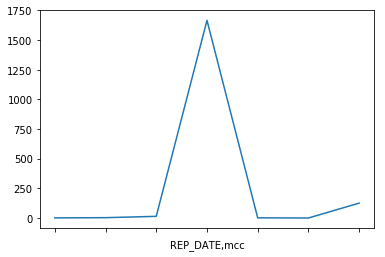

In [89]:
# Generate stat report by country

mcc = 231

df3=df1[df1.index.get_level_values('mcc')==mcc].sort_index(level=['mcc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By operator

In [91]:
# Find out the operator with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                        std_per    diff
            sum    min        mean     max         std                
mcc mnc                                                               
231 1    1786.7    0.2  297.783333  1661.1  669.695054   224.9  1660.9
222 88   6512.4  487.3  930.342857  1756.6  442.453187    47.6  1269.3
730 2    3413.6  208.6  487.657143   965.4  312.491919    64.1   756.8
460 6    2657.7  238.3  379.671429   850.9  215.364193    56.7   612.6
204 4    1021.3    1.4  145.900000   431.3  180.248329   123.5   429.9

                    quantity   cost  charge
REP_DATE   mcc mnc                         
2019-03-25 231 1        16.4    0.1     0.2
2019-03-26 231 1        37.3    0.3     0.5
2019-03-27 231 1        54.5    0.4     0.9
2019-03-28 231 1       118.9  830.5  1661.1
2019-03-29 231 1        36.4    0.3     0.5
2019-03-31 231 1        13.1   61.7   123.5 



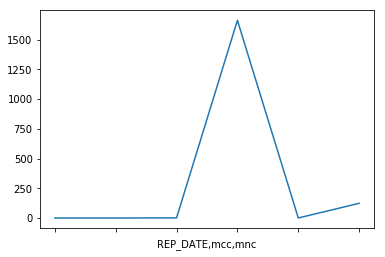

In [92]:
# Generate stat report by country

mcc = 231
mnc = 1

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By customer

In [7]:
# Find out the customer with the biggest increase in Country

df1 = df.groupby(['REP_DATE','mcc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity'] = round(df1['quantity'],1)
df1['charge'] = round(df1['charge'],1)
df1['cost'] = round(df1['cost'],1)

df2=df1.groupby(level=['mcc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per   diff
                   sum    min       mean     max         std               
mcc account_id                                                             
621 352406      2799.0  964.9  1399.5000  1834.1  614.617214    43.9  869.2
460 352342      4826.0  279.3   603.2500  1090.3  305.389526    50.6  811.0
310 352342      3317.3  201.5   414.6625   640.4  148.798713    35.9  438.9
655 352345      3462.3  223.3   432.7875   581.7  112.899126    26.1  358.4
    352366      3462.3  223.3   432.7875   581.7  112.899126    26.1  358.4

In [8]:
df_352406 = df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).reset_index()
df_352406 = df_352406[df_352406.account_id == 352406]
df_352406.head()

mcc account_id  charge                                         std_per  \
                        sum    min         mean     max         std           
0    621     352406  2799.0  964.9  1399.500000  1834.1  614.617214    43.9   
152  730     352406    96.7    0.0    12.087500    28.7   10.131202    83.8   
206  722     352406   134.2    7.1    16.775000    27.3    7.473716    44.6   
209  334     352406    84.5    1.6    10.562500    21.1    7.383560    69.9   
267  714     352406    25.4    0.1     4.233333    14.7    5.382812   127.2   

      diff  
            
0    869.2  
152   28.7  
206   20.2  
209   19.5  
267   14.6

In [9]:
df_352406.sort_values(by=[('charge', 'sum')], ascending=False).head()

mcc account_id  charge                                       std_per  \
                        sum    min       mean     max         std           
0    621     352406  2799.0  964.9  1399.5000  1834.1  614.617214    43.9   
273  310     352406   155.9   14.2    19.4875    28.4    5.272960    27.1   
206  722     352406   134.2    7.1    16.7750    27.3    7.473716    44.6   
152  730     352406    96.7    0.0    12.0875    28.7   10.131202    83.8   
209  334     352406    84.5    1.6    10.5625    21.1    7.383560    69.9   

      diff  
            
0    869.2  
273   14.2  
206   20.2  
152   28.7  
209   19.5

In [108]:
# Find out the customer with the biggest increase in Country and Operator

df1=df.groupby(['REP_DATE','mcc','mnc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                        std_per  \
                       sum    min        mean     max         std           
mcc mnc account_id                                                          
231 1   352342      1786.7    0.2  297.783333  1661.1  669.695054   224.9   
460 6   352342      2646.3  236.7  378.042857   850.9  215.966215    57.1   
260 1   352342      1005.0   29.7  143.571429   342.2   99.220406    69.1   
310 680 352342      2757.1  223.1  393.871429   525.1  106.422362    27.0   
460 2   352342      1791.9  178.7  255.985714   412.1   76.533227    29.9   

                      diff  
                            
mcc mnc account_id          
231 1   352342      1660.9  
460 6   352342       614.2  
260 1   352342       312.5  
310 680 352342       302.0  
460 2   352342       233.4

,REP_DATE,mcc,account_id,quantity,cost,charge
0,2019-04-07,621,352406,1625.2,602.3,964.9
1,2019-04-08,621,352406,3241.2,1155.4,1834.1


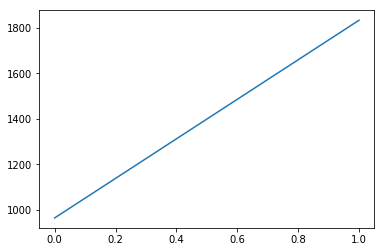

In [10]:
# Generate stat report by country

mcc = 621

account_id = 352406

df3 = df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['REP_DATE']).reset_index()
display(df3)

df3['charge'].plot()
plt.show()

,,,,quantity,cost,charge
REP_DATE,mcc,mnc,account_id,,,
2019-03-25,208,29,352342,475.5,3.2,6.3
2019-03-26,208,29,352342,264.6,2.2,4.3
2019-03-27,208,29,352342,305.8,2.0,4.0
2019-03-28,208,29,352342,298.8,2.1,4.3
2019-03-29,208,29,352342,387.0,3.2,6.4
2019-03-30,208,29,352342,336.4,2.4,4.8
2019-03-31,208,29,352342,164.7,1.2,2.3


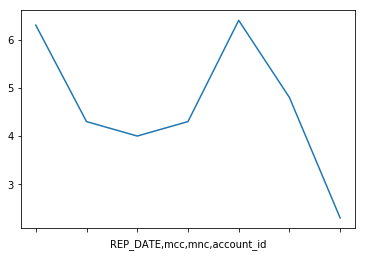

In [124]:
# Generate stat report by country and Operator

mcc = 208
mnc = 29
account_id = 352342

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['mnc','REP_DATE'])
display(df3)

df3['charge'].plot()
plt.show()

### Report by Subscriber

In [13]:
# Download data from OCS DB

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select   
min(u.USAGE_DATE) USAGE_DATE
,u.SUBSCRIBER_ID
,si.IMSI
,si.ICCID
,spn.PHONE_NUMBER
,a.ACCOUNT_NAME
,u.MCC
,u.MNC
,n.NETWORK_NAME
,c.COUNTRY_NAME
,ut.USAGE_TYPE
,sum(uc.CHARGE) Charge
,sum(uc.CHARGE_QUANTITY) Quantity
,u.DEST_PHONE_NUMBER
,u.SESSION_ID
from [10028_usage2019-04].dbo.usage u
inner join [10028_usage2019-04].dbo.USAGE_CHARGES uc on u.USAGE_ID=uc.USAGE_ID
right join [10028].dbo.SUBSCRIBER_IMSIS si on u.SUBSCRIBER_ID = si.SUBSCRIBER_ID and si.END_DATE is null
right join [10028].dbo.SUBSCRIBER_PHONE_NUMBERS spn on u.SUBSCRIBER_ID = spn.SUBSCRIBER_ID and spn.END_DATE is null
inner join [10028].dbo.USAGE_TYPE ut on u.USAGE_TYPE = ut.USAGE_TYPE_ID
right join [10028].dbo.SUBSCRIBERS s on s.SUBSCRIBER_ID = u.SUBSCRIBER_ID
right join [10028].dbo.ACCOUNTS a on a.ACCOUNT_ID = s.ACCOUNT_ID
right join [10028].dbo.RDB_NETWORK_IMSI_PREFIXES net on net.MCC = u.MCC and net.MNC= u.MNC
right join [10028].dbo.RDB_NETWORKS n on net.NETWORK_ID = n.NETWORK_ID
right join [10028].dbo.RDB_COUNTRIES c on c.COUNTRY_ID = n.COUNTRY_ID
where uc.ACCOUNT_ID = 352406 AND u.MCC IN (621, 334)
AND u.USAGE_DATE BETWEEN '2019-04-07 00:00:00' AND '2019-04-09 00:00:00'
group by   u.SUBSCRIBER_ID,
si.IMSI, si.ICCID , spn.PHONE_NUMBER,a.ACCOUNT_NAME,
u.MCC , u.MNC  , n.NETWORK_NAME , c.COUNTRY_NAME, ut.USAGE_TYPE,
u.SESSION_ID , u.DEST_PHONE_NUMBER
order by min(u.USAGE_DATE),u.SUBSCRIBER_ID
'''

df_subscribers = pd.read_sql_query(sql_srt, cnxn, parse_dates={'USAGE_DATE': '%d/%m/%ysort'})
cnxn.close()

df_subscribers.head()

,USAGE_DATE,SUBSCRIBER_ID,IMSI,ICCID,PHONE_NUMBER,ACCOUNT_NAME,MCC,MNC,NETWORK_NAME,COUNTRY_NAME,USAGE_TYPE,Charge,Quantity,DEST_PHONE_NUMBER,SESSION_ID
0,2019-04-07 00:06:24.387,1573717,724390000684331,89553900030006843312,5512974034185,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00001,0.00025,None,d0-EPGrh.live.partner.com;1538597561;55767709;...
1,2019-04-07 00:30:25.747,1573501,724390993549584,89553900230061175630,5511957516715,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.82394,22.88730,None,d1-EPGrh.live.partner.com;1538597562;55793236;...
2,2019-04-07 00:41:49.357,1573668,724390003308068,89553900030033080680,5511975450828,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00000,0.00010,None,d1-EPGrh.live.partner.com;1528923558;130278919...
3,2019-04-07 01:07:00.697,1573698,724390996140658,89553910300006736388,5511948346245,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.19620,5.45000,None,d0-EPGrh.live.partner.com;1528923558;129735267...
4,2019-04-07 01:29:27.200,1573581,724390999264340,89553910300020011834,5511940195221,Nextel,621,20,Airtel/ZAIN/Econet,Nigeria,Incoming Text,0.00000,1.00000,None,18022718-1554593357


In [15]:
df_subscribers['REP_DATE'] = df_subscribers.USAGE_DATE.dt.strftime('%Y-%m-%d')

In [18]:
downloads = 'C:/Users/balob/Downloads'
df_subscribers.groupby(['REP_DATE','IMSI','MCC','USAGE_TYPE','DEST_PHONE_NUMBER'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by='Charge',
                                                                              ascending=False).head(15)

,REP_DATE,IMSI,MCC,USAGE_TYPE,DEST_PHONE_NUMBER,Charge,Quantity
39,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531253,65.2740,94.60000
86,2019-04-08,724390999264281,621,VOIP Outgoing Call,236750531296,61.2030,88.70000
134,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531250,57.3505,83.11667
163,2019-04-08,724390999264339,621,VOIP Outgoing Call,236750531299,55.0045,79.71666
43,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531299,46.6900,67.66667
96,2019-04-08,724390999264289,621,VOIP Outgoing Call,236750531255,44.8500,65.00000
124,2019-04-08,724390999264292,621,VOIP Outgoing Call,236750531253,42.1130,61.03333
135,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531296,41.4230,60.03333
25,2019-04-07,724390999264337,621,VOIP Outgoing Call,236750531299,41.4115,60.01667
115,2019-04-08,724390999264291,621,VOIP Outgoing Call,236750531254,41.4000,60.00000


In [22]:
df_subscribers.groupby(['IMSI','MCC','USAGE_TYPE'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by=['IMSI','Charge'],
                                                                              ascending=False).head(25)

,IMSI,MCC,USAGE_TYPE,Charge,Quantity
45,724390999264340,621,VOIP Outgoing Call,137.54600,199.20000
44,724390999264340,621,Outgoing Call,101.00000,202.00000
43,724390999264340,621,Incoming Text,0.00000,2.00000
42,724390999264339,621,VOIP Outgoing Call,142.91500,206.78334
41,724390999264339,621,Outgoing Call,101.00001,201.99999
40,724390999264339,621,Incoming Text,0.00000,2.00000
39,724390999264338,621,VOIP Outgoing Call,276.29800,400.18335
38,724390999264338,621,Outgoing Call,201.00000,402.00000
37,724390999264338,621,Incoming Text,0.00000,2.00000
36,724390999264337,621,VOIP Outgoing Call,140.08150,203.01667
